In [1]:
import acl
import cv2
from PIL import Image, ImageDraw
import sys
# define acllite library path
sys.path.append('../../Common/acllite')
# modules of acllite library
from acllite_model import AclLiteModel
from acllite_resource import AclLiteResource
from src.model import preprocessing, postprocessing

In [2]:
# define device id & model path
device_id = 0
model_path = "model/yolov3.om"

# define image & coco_names paths
img_path = "../../Common/data/person.jpg"
coco_names_path = "../../Common/data/coco.names"

In [3]:
with open(coco_names_path) as fd:
    coco_labels = fd.readlines()

coco_labels = [i[:-1] for i in coco_labels][0:]

In [4]:
# initialize acllite library
acl_resource = AclLiteResource()
acl_resource.init()

# load *.om model
model = AclLiteModel(model_path, device_id)

init resource stage:
Init resource success
Init model resource start...
[AclLiteModel] create model output dataset:
malloc output 0, size 2758080
malloc output 1, size 689520
malloc output 2, size 172380
Create model output dataset success
Init model resource success


In [5]:
# read image
img_org_bgr = cv2.imread(img_path)

In [6]:
# 1) pre-processing stage
data = preprocessing(img_org_bgr,model._model_desc)

model input size 1
input  0
model input dims ({'name': 'input/input_data', 'dimCount': 4, 'dims': [1, 416, 416, 3]}, 0)
model input datatype 4
model output size 3
output  0
model output dims ({'name': 'pred_sbbox/concat_2:0', 'dimCount': 5, 'dims': [1, 52, 52, 3, 85]}, 0)
model output datatype 0
output  1
model output dims ({'name': 'pred_mbbox/concat_2:0', 'dimCount': 5, 'dims': [1, 26, 26, 3, 85]}, 0)
model output datatype 0
output  2
model output dims ({'name': 'pred_lbbox/concat_2:0', 'dimCount': 5, 'dims': [1, 13, 13, 3, 85]}, 0)
model output datatype 0
[Model] class Model init resource stage success
img_resized shape (416, 416, 3)


In [7]:
%timeit -n 10 -r 3
# 2) model execution(forward) stage
result_list = model.execute([data,]) 

In [8]:
# 3) post-processing the raw predictions
bboxes = postprocessing(model, result_list, img_org_bgr, 0.3, 0.45)

In [9]:
img_out = Image.open(img_path)
img1 = ImageDraw.Draw(img_out)
for bbox in bboxes:
    img1.rectangle(list(bbox[:4]), outline ="red", width=2)
    print(bbox[:4], bbox[4], int(bbox[5]), coco_labels[int(bbox[5])])
    img1.rectangle((bbox[0], bbox[1] -15, bbox[0] + len(coco_labels[int(bbox[5])])*8, bbox[1]), 
                outline = (255,255,255), width=10) 
    img1.text((bbox[0]+5, bbox[1]-15), coco_labels[int(bbox[5])], (255,0,0), thickness=40)

[191.08174133  91.61539459 278.91827393 375.07693481] 1.0 0 person
[ 63.8942337  266.78366089 207.2596283  347.21636963] 0.9892578125 16 dog
[397.21154785 134.8846283  608.1730957  362.96154785] 0.998046875 17 horse


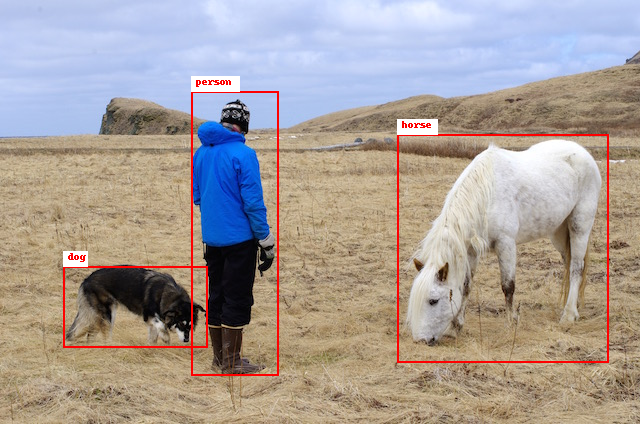

In [10]:
img_out